This notebook is used to train and test the model. It is also used to generate the results.  
First we import the training data.

In [1]:
import pandas as pd
import numpy as np

In [2]:
X_y_train = pd.read_pickle('../../fulldata/processed/X_y_train.pkl')
X_y_test = pd.read_pickle('../../fulldata/processed/X_y_test.pkl')

In [3]:
X_y_train.head()

,subject,time,trial,currentobject,rt,right_pupil,left_pupil,right_gaze_x,right_gaze_y,left_gaze_x,left_gaze_y
st,,,,,,,,,,,
"(847, 1)",847,176833,1,NaN,0.581417,0.668147,0.901490,-1.062249,-0.474015,-0.933822,-0.014521
"(847, 1)",847,176842,1,Fixation,0.581417,0.668147,0.901490,-1.062249,-0.474015,-0.933822,-0.014521
"(847, 1)",847,176851,1,Fixation,0.581417,0.668147,0.901490,-1.062249,-0.474015,-0.933822,-0.014521
"(847, 1)",847,176858,1,Fixation,0.581417,0.668147,0.901490,-1.062249,-0.474015,-0.933822,-0.014521
"(847, 1)",847,176867,1,Fixation,0.581417,0.630639,0.876603,-1.052113,-0.395679,-0.911996,-0.053571


we need to limit the data to only the samples in the "Zeros" phase, as it contains the samples of the test

In [4]:
X_y_train = X_y_train.query('currentobject == "Zeros"')
X_y_train.head()

,subject,time,trial,currentobject,rt,right_pupil,left_pupil,right_gaze_x,right_gaze_y,left_gaze_x,left_gaze_y
st,,,,,,,,,,,
"(847, 1)",847,178892,1,Zeros,0.581417,-0.169095,-0.040198,-0.593431,0.593276,-0.093337,0.198608
"(847, 1)",847,178900,1,Zeros,0.581417,-0.200981,-0.025474,-0.593030,0.776339,-0.096639,0.326551
"(847, 1)",847,178908,1,Zeros,0.581417,-0.232867,-0.010751,-0.592628,0.959402,-0.099941,0.454494
"(847, 1)",847,178916,1,Zeros,0.581417,-0.264752,0.003973,-0.592227,1.142465,-0.103243,0.582436
"(847, 1)",847,178925,1,Zeros,0.581417,-0.296638,0.018696,-0.591826,1.325527,-0.106545,0.710379


Because of the nature of the test, the number of samples in the "Zeros" phase is varied, so we need to limit the number of samples the same number. We do this by picking a minimum number of samples in the "Zeros" phase, then we can structure the data in an array.

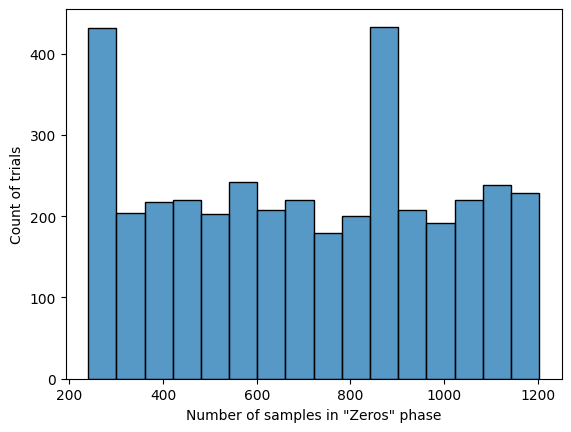

count    3843.000000
mean      714.167057
std       293.188223
min       240.000000
25%       480.000000
50%       720.000000
75%       962.000000
max      1203.000000
Name: time, dtype: float64

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(data = X_y_train.groupby('st').count(), x = 'time')
plt.xlabel('Number of samples in "Zeros" phase')
plt.ylabel('Count of trials')
plt.show()
X_y_train.groupby('st').count().time.describe()

We can see that the minimum number of samples in the "Zeros" phase is 240, so we will limit the training data to the last 200 samples of the "Zeros" phase.

In [6]:
def windowcut(df, window):
    df = df.copy()
    dfout = df['time'].groupby('st').apply(list).reset_index().set_index('st')
    ys = df['rt'].groupby('st').mean()
    for col in ['right_pupil', 'left_pupil', 'right_gaze_x', 'right_gaze_y', 'left_gaze_x', 'left_gaze_y']:
        temp = df[col].groupby('st').apply(list).reset_index().set_index('st')
        dfout[col] = temp[col]
    X = dfout[['right_pupil', 'left_pupil', 'right_gaze_x', 'left_gaze_x', 'right_gaze_y', 'left_gaze_y']].reset_index(drop=True).to_numpy()
    X = np.array([[ii[-window:] for ii in i] for i in X])
    y = ys.reset_index(drop=True).to_numpy()
    y = np.array([[i] for i in y])
    return X, y

Now we have our X and y data:

In [7]:
X_train, y_train = windowcut(X_y_train, 200)
X_test, y_test = windowcut(X_y_test, 200)

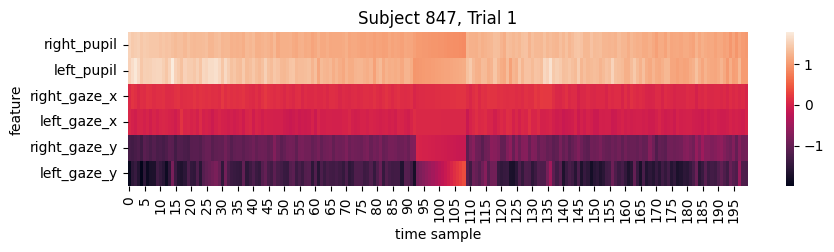

In [8]:
plt.figure(figsize=(10, 2))
plt.title('Subject 847, Trial 1')
sns.heatmap(X_train[0])
plt.xlabel('time sample')
plt.ylabel('feature')
plt.yticks(ticks = np.arange(6)+.5, labels=['right_pupil', 'left_pupil', 'right_gaze_x', 'left_gaze_x', 'right_gaze_y', 'left_gaze_y'], rotation=0)
plt.show()

Lets train the models:

In [9]:
validation_losses = {}
test_losses = {}

In [10]:
import tensorflow as tf

2023-05-02 03:32:23.526670: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


RandomBaseline test loss:  2.084489583969116


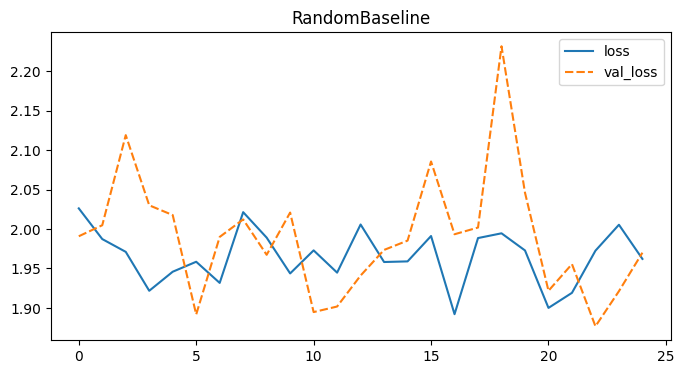

In [14]:
from RandomBaseline import RandomBaseline 
model = RandomBaseline()
model.compile(optimizer='adam', loss='mean_squared_error')
randomBaselineTraining = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.2, verbose=0)
validation_losses['RandomBaseline'] = randomBaselineTraining.history['val_loss']
test_loss = model.evaluate(X_test, y_test, verbose=0)
test_losses['RandomBaseline'] = test_loss
plt.figure(figsize=(8, 4))
print('RandomBaseline test loss: ', test_loss)
plt.title('RandomBaseline')
sns.lineplot(randomBaselineTraining.history)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()


FullyConnectedNeuralNetwork test loss:  1.0770714282989502


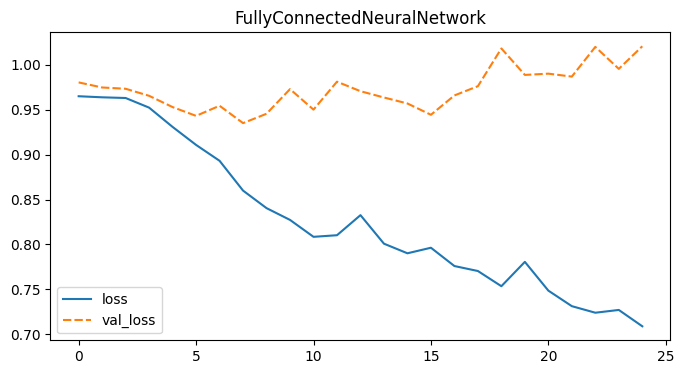

In [15]:
from FullyConnectedNeuralNetwork import FullyConnectedNeuralNetwork
model = FullyConnectedNeuralNetwork()
model.compile(optimizer='adam', loss='mean_squared_error')
fullyConnectedTraining = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.2, verbose=0)
validation_losses['FullyConnectedNeuralNetwork'] = fullyConnectedTraining.history['val_loss']
test_losses['FullyConnectedNeuralNetwork'] = model.evaluate(X_test, y_test, verbose=0)
plt.figure(figsize=(8, 4))
print('FullyConnectedNeuralNetwork test loss: ', test_losses['FullyConnectedNeuralNetwork'])
plt.title('FullyConnectedNeuralNetwork')
sns.lineplot(fullyConnectedTraining.history)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()

2023-05-02 03:37:08.815954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-02 03:37:08.817343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-02 03:37:08.818288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

LongShortTermMemoryNetwork test loss:  1.5276618003845215


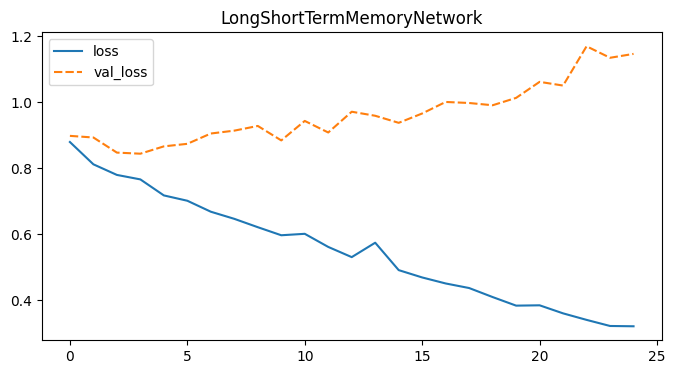

In [16]:
from LongShortTermMemoryNetwork import LongShortTermMemoryNetwork
model = LongShortTermMemoryNetwork()
model.compile(optimizer='adam', loss='mean_squared_error')
lstmTraining = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.2, verbose=0)
validation_losses['LongShortTermMemoryNetwork'] = lstmTraining.history['val_loss']
test_losses['LongShortTermMemoryNetwork'] = model.evaluate(X_test, y_test, verbose=0)
plt.figure(figsize=(8, 4))
print('LongShortTermMemoryNetwork test loss: ', test_losses['LongShortTermMemoryNetwork'])
plt.title('LongShortTermMemoryNetwork')
sns.lineplot(lstmTraining.history)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()

ConvolutedNeuralNetwork test loss:  0.9206199049949646


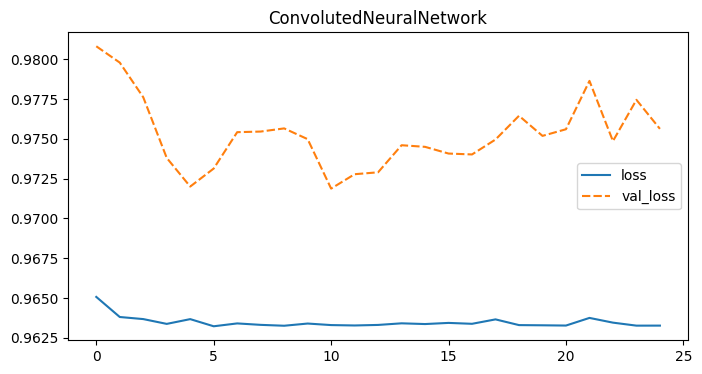

In [18]:
from ConvolutedNeuralNetwork import ConvolutedNeuralNetwork
model = ConvolutedNeuralNetwork()
model.compile(optimizer='adam', loss='mean_squared_error')
convolutedNeuralNetworkTraining = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.2, verbose=0)
validation_losses['ConvolutedNeuralNetwork'] = convolutedNeuralNetworkTraining.history['val_loss']
test_losses['ConvolutedNeuralNetwork'] = model.evaluate(X_test, y_test, verbose=0)
plt.figure(figsize=(8, 4))
print('ConvolutedNeuralNetwork test loss: ', test_losses['ConvolutedNeuralNetwork'])
plt.title('ConvolutedNeuralNetwork')
sns.lineplot(convolutedNeuralNetworkTraining.history)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()

In [32]:
validation_losses_frame = pd.DataFrame(validation_losses)
validation_losses_frame = validation_losses_frame[['FullyConnectedNeuralNetwork','LongShortTermMemoryNetwork', 'ConvolutedNeuralNetwork', 'RandomBaseline']]

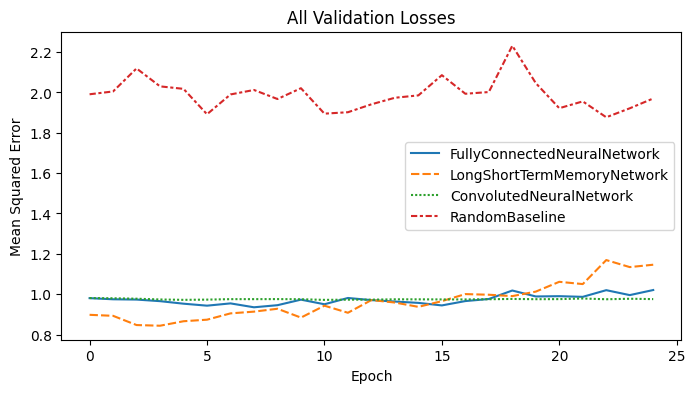

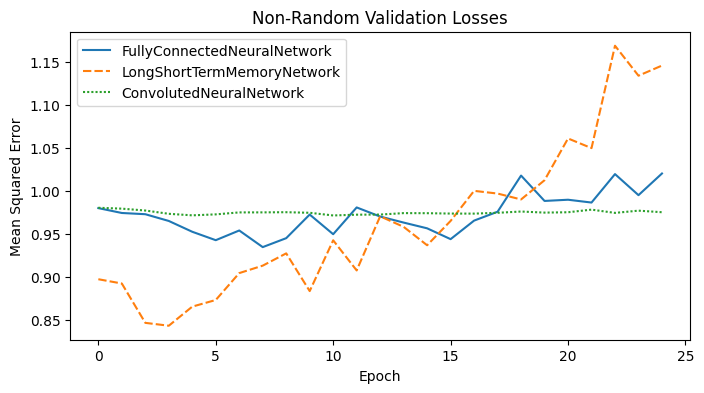

In [39]:
# validation losses

plt.figure(figsize=(8, 4))
plt.title('All Validation Losses')
sns.lineplot(data = validation_losses_frame)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()

plt.figure(figsize=(8, 4))
plt.title('Non-Random Validation Losses')
sns.lineplot(data = validation_losses_frame[['FullyConnectedNeuralNetwork', 'LongShortTermMemoryNetwork', 'ConvolutedNeuralNetwork']])
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()

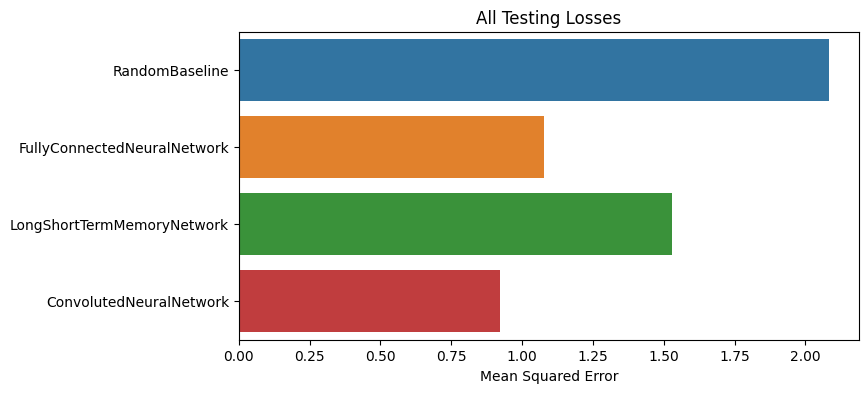

In [40]:
# testing losses
plt.figure(figsize=(8, 4))
plt.title('All Testing Losses')
sns.barplot(y = list(test_losses.keys()), x = list(test_losses.values()))
plt.xlabel('Mean Squared Error')
plt.show()